In [1]:
import dicom
import inspect
import pylab
import numpy as np
from glob import glob
import os

import matplotlib
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from utils.data_manager import load_patient, normalize

import math
from sys import stdout

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [3]:
conv_model = load_model('models/model-babystep3-composite-tertiary-classification.h5')
conv_model.layers

In [169]:
conv = conv_model.layers[0]
conv.get_weights

<bound method Layer.get_weights of <keras.layers.convolutional.Convolution2D object at 0x7fe8262b2a90>>

In [73]:
ways = [
    [Input(shape=(512,512,1))],
    [Input(shape=(512,512,1))],
    [Input(shape=(512,512,1))]
]

common_way = [
    MaxPooling2D(pool_size=(2,2)),
    Convolution2D(32, 3, 3, activation='relu', border_mode='same'),
    MaxPooling2D(pool_size=(2,2)),
    Convolution2D(32, 3, 3, activation='relu', border_mode='same'),
    MaxPooling2D(pool_size=(2,2)),
    Convolution2D(64, 3, 3, activation='relu', border_mode='same'),
    BatchNormalization(),
    Convolution2D(128, 3, 3, activation='relu', border_mode='same'),
    MaxPooling2D(pool_size=(2,2))
]

for i in range(3):
    for idx, layer in enumerate(common_way):
        ways[i].append(layer(ways[i][idx]))

ways = np.array(ways)
        
merged = merge(ways[:,-1], mode='concat')

c1 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(merged)
m1 = MaxPooling2D(pool_size=(2,2))(c1)
c2 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(m1)

up1 = merge([UpSampling2D(size=(2, 2))(c2), c1], mode='concat', concat_axis=3)
c3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up1)

up2 = merge([UpSampling2D(size=(2, 2))(c3)] + list(ways[:,-2]), mode='concat', concat_axis=3)
c4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up2)

up3 = merge([UpSampling2D(size=(2, 2))(c4)] + list(ways[:,4]), mode='concat', concat_axis=3)
c5 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up3)

up4 = merge([UpSampling2D(size=(2, 2))(c5)] + list(ways[:,2]), mode='concat', concat_axis=3)
c6 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up4)

up5 = merge([UpSampling2D(size=(2, 2))(c6)] + list(ways[:,0]), mode='concat', concat_axis=3)

c7 = Convolution2D(64, 3, 3, activation='sigmoid', border_mode='same')(up5)
c8 = Convolution2D(4, 3, 3, activation='sigmoid', border_mode='same')(c7)


model = Model(input=list(ways[:,0]), output=c8)
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [66]:
p1 = np.load('data/malign023.npy')
p1
image = p1.all()['image']
tag = p1.all()['tag']
X = normalize(image.reshape(image.shape[0], 512, 512, 1))
y = tag.reshape(image.shape[0], 512, 512, 8)[:,:,:,[0,1,2,3]]
num = X.shape[0]
def generate(k):
    xx1 = []
    xx2 = []
    xx3 = []
    yy = []
    for i in range(k):
        c = np.random.randint(num - 2) + 1
        xx1.append(X[c-1])
        xx2.append(X[c])
        xx3.append(X[c+1])
        yy.append(y[c])
    return np.stack(xx1), np.stack(xx2), np.stack(xx3), np.stack(yy)


In [67]:
epoch = 10
batch = 20
for i in range(epoch):
    print('epoch %d' % i)
    loss = 0
    for j in range(batch):
        xx1, xx2, xx3, yy = generate(1)
        l = model.train_on_batch([xx1, xx2, xx3], yy)
        loss += l[1]
        stdout.write('\rBatch %d : loss %f' % (j + 1, loss / (j + 1)))
    print("")

epoch 0
Batch 15 : loss 0.852843

KeyboardInterrupt: 

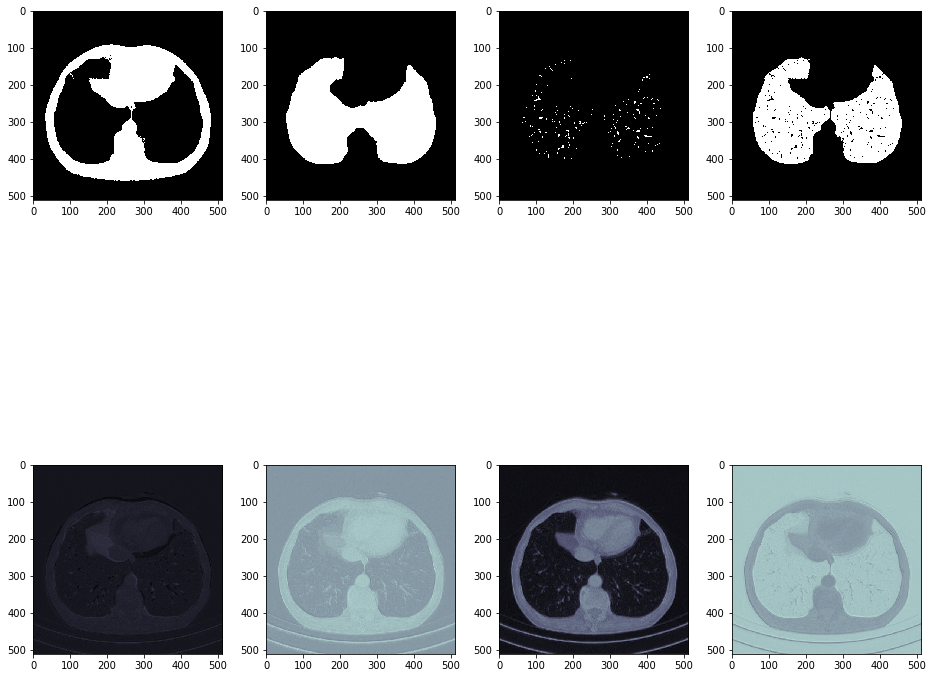

In [74]:
xx1, xx2, xx3, yy = generate(1)
pred = model.predict([xx1, xx2, xx3])[0] ## for a slice
plt.figure(figsize=(16,16))
for i in range(4):
    plt.subplot(4,4, i+1)
    plt.imshow(yy[0,:,:,i], plt.cm.bone)

for i in range(4):
    plt.subplot(4,4, 8 + i+1)
    plt.imshow(pred[:,:,i], plt.cm.bone)
plt.show()

In [70]:
model.compile(optimizer=Adam(lr=1e-5), loss='mse')
model.save('single-pass-segment-detection.h5')
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [71]:
model2 = load_model('single-pass-segment-detection.h5')
model2.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

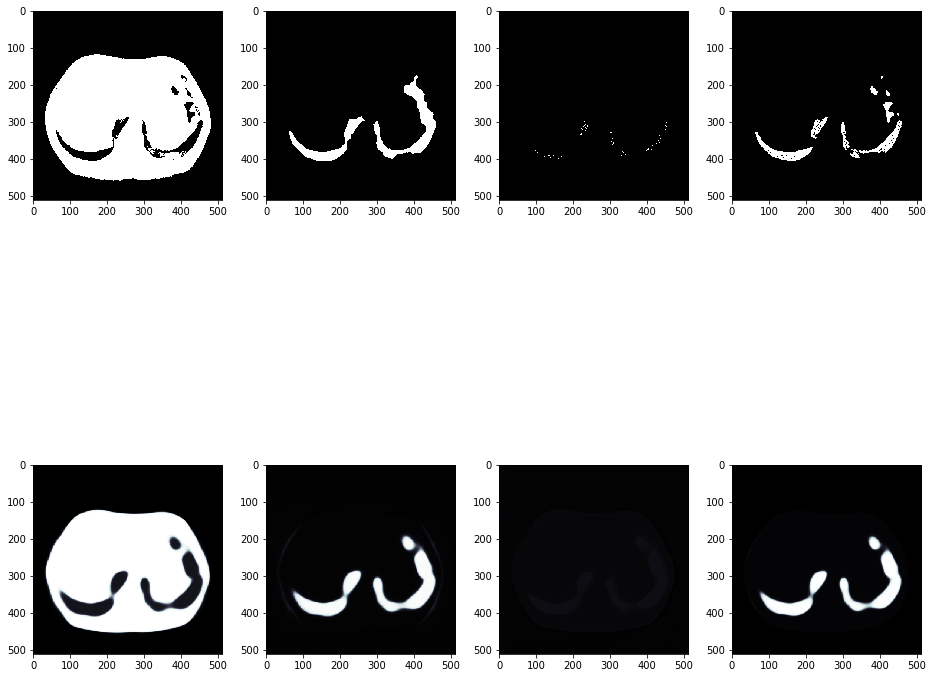

In [72]:
xx1, xx2, xx3, yy = generate(1)
pred = model2.predict([xx1, xx2, xx3])[0] ## for a slice
plt.figure(figsize=(16,16))
for i in range(4):
    plt.subplot(4,4, i+1)
    plt.imshow(yy[0,:,:,i], plt.cm.bone)

for i in range(4):
    plt.subplot(4,4, 8 + i+1)
    plt.imshow(pred[:,:,i], plt.cm.bone)
plt.show()